# task definition
Train a model to classify a movie rewiew in positive or negative polarity.

# data collection
dataset of IMDb, available at: http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

it uses 'wget' python module. Use ```pip install wget``` to install it!


In [1]:
import wget
import os
import tarfile

filename = "dataset/aclImdb_v1.tar.gz"

dataset_link = "http://ai.stanford.edu/~amaas/data/sentiment/{}".format("aclImdb_v1.tar.gz")
try:
    os.mkdir("dataset")
except OSError:
    pass

if not os.path.isfile(filename):
    file = wget.download(dataset_link, out='dataset/aclImdb_v1.tar.gz')

    tar = tarfile.open(filename, "r:gz")
    tar.extractall("dataset")
    tar.close()

# data load and visualization

In [2]:
# montar dataset com valores de 1 a 4 e de 7 a 10, ao invés de binário
dataset_path = 'dataset/aclImdb'
train_positive_files = ['train/pos/'+f for f in os.listdir(dataset_path+'/train/pos') \
                        if os.path.isfile(os.path.join(dataset_path+'/train/pos', f))]

train_negative_files = ['train/neg/'+f for f in os.listdir(dataset_path+'/train/neg') \
                        if os.path.isfile(os.path.join(dataset_path+'/train/neg', f))]

test_positive_files = ['test/pos/'+f for f in os.listdir(dataset_path+'/test/pos') \
                       if os.path.isfile(os.path.join(dataset_path+'/test/pos', f))]

test_negative_files = ['test/neg/'+f for f in os.listdir(dataset_path+'/test/neg') \
                       if os.path.isfile(os.path.join(dataset_path+'/test/neg', f))]

all_files = list(set().union(train_positive_files,train_negative_files, test_positive_files, test_negative_files))

In [3]:
dataset = {'trainset':[], 
           'polarity':[], 
           'review':[]}

for file in all_files:
    polarity = file.split('.')[0].split('_')[1]
    with open(os.path.join(dataset_path, file), 'r') as text_file:
        dataset['trainset'].append(file.split('/')[0])
        dataset['polarity'].append(polarity)
        dataset['review'].append(text_file.readlines()[0])

In [4]:
import pandas as pd
dataframe = pd.DataFrame(data=dataset)

In [5]:
dataframe.head()

,trainset,polarity,review
0,train,1,I think if they made ANY MONEY make a complete...
1,test,9,I originally saw this movie in a movie theater...
2,test,1,Do yourself a favor and stay away from this fi...
3,test,3,It took me a few years to hunt down this title...
4,test,10,"This movie is amazing. It is funny, sexy, viol..."


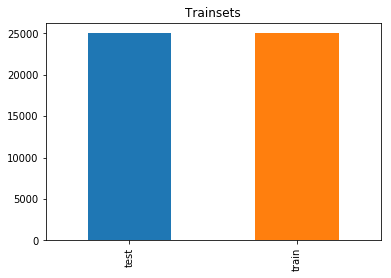

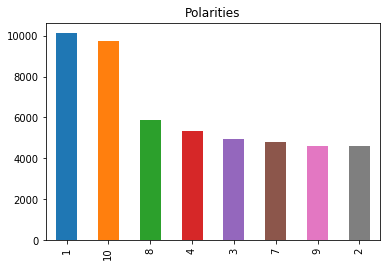

In [7]:
import matplotlib.pyplot as plt

dataframe['trainset'].value_counts().plot(kind='bar',title='Trainsets')
plt.show()

dataframe['polarity'].value_counts().plot(kind='bar',title='Polarities')
plt.show()

In [8]:
dataframe['review_size'] = dataframe['review'].apply(len)
dataframe['review_size'].describe()

count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: review_size, dtype: float64

In [9]:
dataframe[dataframe['review_size']==32]

,trainset,polarity,review,review_size
6651,test,2,"Read the book, forget the movie!",32


# pre processing

In [9]:
import re

REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def preprocess_reviews(review):
    review = REPLACE_NO_SPACE.sub("", review.lower())
    review = REPLACE_WITH_SPACE.sub(" ", review)
    
    return review

dataframe['clean_review'] = dataframe['review'].apply(preprocess_reviews)

In [10]:
dataframe.head()

,trainset,polarity,review,review_size,clean_review
0,test,10,Suzumiya Haruhi no Yuuutsu is a very high-rate...,1007,suzumiya haruhi no yuuutsu is a very high rate...
1,train,3,"Tom Wolfe's sprawling, brilliantly observed sa...",817,tom wolfes sprawling brilliantly observed sati...
2,train,7,"Another fun, witty, frothy RKO musical with As...",639,another fun witty frothy rko musical with asta...
3,train,10,From the excellent acting of an extremely impr...,1695,from the excellent acting of an extremely impr...
4,test,1,"This contains some spoiler information, but th...",1702,this contains some spoiler information but the...


# feature engineering

In [11]:
train_reviews = dataframe[dataframe['trainset'] == 'train']['clean_review'].values.tolist()
train_classes = dataframe[dataframe['trainset'] == 'train']['polarity'].values.tolist()
test_reviews = dataframe[dataframe['trainset'] == 'test']['clean_review'].values.tolist()
test_classes = dataframe[dataframe['trainset'] == 'test']['polarity'].values.tolist()

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
import pickle

cv = CountVectorizer(binary=True)
cv.fit(train_reviews)
X = cv.transform(train_reviews)
X_test = cv.transform(test_reviews)

In [13]:
#save cv model
try:
    os.mkdir("models")
except OSError:
    pass

s = pickle.dumps(cv)
with open('models/cv_pickle', 'wb') as pickle_file:
    pickle_file.write(s)

# Training

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, train_classes, train_size = 0.75
)

/Users/erick/virtualenvs/NLP-IA_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [15]:
for c in [0.001, 0.005, 0.009, 0.01, 0.015, 0.02, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))
    

Accuracy for C=0.001: 0.38144
Accuracy for C=0.005: 0.41312
Accuracy for C=0.009: 0.41536
Accuracy for C=0.01: 0.41808
Accuracy for C=0.015: 0.416
Accuracy for C=0.02: 0.41824
Accuracy for C=1: 0.38128


In [16]:
final_model = LogisticRegression(C=0.009)
final_model.fit(X, train_classes)
print ("Final Accuracy: %s" 
       % accuracy_score(test_classes, final_model.predict(X_test)))

Final Accuracy: 0.42052


In [17]:
s = pickle.dumps(final_model)
with open('models/final_model', 'wb') as pickle_file:
    pickle_file.write(s)

# evaluation

In [18]:
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), final_model.coef_[0]
    )
}
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_positive)
        
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_negative)

('worst', 0.8032095803927547)
('awful', 0.5351479745293349)
('waste', 0.4823428484521984)
('bad', 0.4246554490570171)
('terrible', 0.4119435134005384)
('best', -0.38899174332628916)
('great', -0.37463480959983214)
('excellent', -0.37156543139192405)
('the', -0.28493251613846315)
('and', -0.25938516914643095)


# deploying
install flask using ```pip install flask```. Let's create a REST service to make it available!
The following code must be put in a python file ```app.py```. 

In the same directory of the previous file, run the commands bellow:

```chmod a+x app.py```

```python app.py```

In [ ]:
from flask import Flask, request
from sklearn.feature_extraction.text import CountVectorizer
import re
import pickle

# regular expressions
REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

# load vectorization model
pickle_file = open('models/cv_pickle', 'rb')
cv = pickle.loads(pickle_file.read())

# load ML model
pickle_file = open('models/final_model', 'rb')
final_model = pickle.loads(pickle_file.read())


# prepare input to be classified
def prepare_input(review):
    review = REPLACE_NO_SPACE.sub("", review.lower())
    review = REPLACE_WITH_SPACE.sub(" ", review)

    return cv.transform([review])


app = Flask(__name__)

@app.route('/api/v1.0/scorefy', methods=["GET"])
def scorefy():
    query_parameters = request.args
    review = query_parameters.get('r')
    return final_model.predict(prepare_input(review))[0]


if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000, debug=True)
